## **Setup**

In [61]:
# !tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.client import device_lib
print(str(device_lib.list_local_devices()[1]))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvcc -V

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22515023872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6524490242143261004
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [62]:
# 표준 라이브러리
import gc  # 가비지 컬렉션 관련 라이브러리
import os  # 운영체제 관련 라이브러리
import pickle  # 파이썬 객체 직렬화 라이브러리
from functools import partial  # 함수 일부 적용 라이브러리
from glob import glob  # 파일 경로 관련 라이브러리

# 데이터 처리 및 시각화 관련 라이브러리
import matplotlib.pyplot as plt  # 시각화 라이브러리
import numpy as np  # 배열 및 수학 연산 라이브러리
import pandas as pd  # 데이터 프레임 라이브러리
from PIL import Image  # 이미지 처리 라이브러리

# 머신러닝, 데이터 전처리 및 증강 관련 라이브러리
import collections  # 컬렉션 자료구조 관련 라이브러리
from imblearn.over_sampling import SMOTE  # 클래스 불균형 처리 라이브러리
from sklearn.model_selection import train_test_split  # 데이터 분할 라이브러리
from tqdm import tqdm  # 진행 상황 표시 라이브러리

# TensorFlow 및 Keras 관련 라이브러리
from keras.backend import clear_session  # Keras 백엔드 초기화 함수
from keras.wrappers.scikit_learn import KerasClassifier  # Keras 모델을 scikit-learn 호환으로 래핑
from scipy.stats import uniform, randint  # 확률 분포 관련 라이브러리
from tensorflow.keras import Model  # Keras 모델 클래스
from tensorflow.keras.initializers import HeNormal  # He 초기화
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPool2D  # 다양한 레이어 관련 라이브러리
from tensorflow.keras.layers.experimental.preprocessing import Rescaling  # 데이터 스케일 조정 라이브러리
from tensorflow.keras.losses import categorical_crossentropy  # 다중 클래스 분류 손실 함수
from tensorflow.keras.models import Sequential  # Sequential 모델 클래스
from tensorflow.keras.optimizers import Adam  # Adam 옵티마이저
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # 이미지 데이터 증강 라이브러리
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping  # 모델 콜백 관련 라이브러리

In [63]:
# 현재 작업 디렉토리를 가져옵니다.
curr_dir = os.getcwd()
# 현재 디렉토리와 함께 경로를 조합하는 함수를 생성합니다.
join_with_curr = partial(os.path.join, curr_dir)

In [64]:
def create_path(path):
    # 지정된 경로가 존재하지 않으면 디렉토리를 생성하고 메시지를 출력합니다.
    if not os.path.exists(path):
        os.makedirs(path)
        print(f'{path}를 생성했습니다.')
        return path
    else:
        # 경로가 이미 존재하는 경우 메시지를 출력합니다.
        print(f"{path} 이미 존재합니다.")
        return path

In [65]:
# 주어진 감정 딕셔너리는 각 감정 레이블에 해당하는 숫자를 나타냅니다.
emotions = {
    '0': 'angry',          # 0: 화남
    '1': 'embarrassed',    # 1: 당황
    '2': 'happy',          # 2: 행복
    '3': 'sad',            # 3: 슬픔
    '4': 'neutral'         # 4: 중립
}

# 새로운 딕셔너리 emo를 생성하여 감정 딕셔너리의 키와 값을 반대로 뒤집습니다.
emo = {
    value: key        # 감정 레이블을 키로 사용하고 해당하는 숫자를 값으로 사용합니다.
    for key, value in emotions.items()  # 감정 딕셔너리의 각 항목을 반복하면서 처리합니다.
}

# 생성된 emo 딕셔너리를 출력합니다.
print(emo)

# 변수 num_classes는 감정 클래스의 수를 저장하며, 이는 감정 딕셔너리의 항목 수와 동일합니다.
num_classes = len(emotions)


{'angry': '0', 'embarrassed': '1', 'happy': '2', 'sad': '3', 'neutral': '4'}


## **데이터 준비**

감정 분석을 위한 이미지 데이터셋을 준비하는 과정입니다.

---
### **데이터 로딩 함수 (load_data) 정의**
CSV 파일로부터 데이터를 로드하고, 이미지와 레이블을 NumPy 배열로 변환하는 함수를 정의합니다.  
try-except 블록을 사용하여 파일이 존재하지 않는 경우 오류 메시지를 출력합니다.

### **데이터 존재 여부 검사 함수 (exist_check) 정의**

주어진 데이터셋의 각 이미지 파일이 실제로 존재하는지 확인합니다.  
파일이 존재하지 않는 경우 해당 파일에 대한 오류 메시지를 출력하고, 존재하는 경우 새로운 CSV 파일을 생성합니다.

### **CSV 파일 병합 함수 (merge_csv_vertical) 정의**
주어진 디렉토리에 있는 모든 CSV 파일들을 병합하여 하나의 파일로 만드는 함수입니다.  
이미 병합된 파일이 존재하는 경우, 함수는 추가 작업 없이 종료됩니다.

In [66]:
def load_data(data_file):
    data_file = pd.read_csv(data_file) # pandas를 이용하여 CSV 파일을 읽습니다.
    x_data = [] # 이미지 배열을 저장할 리스트입니다
    y_data = [] # 감정 레이블을 저장할 리스트입니다.
    
    for i in range(len(data_file)):
        try:
            img = Image.open(data_file.iloc[i]['path'])   # PIL을 사용하여 이미지를 엽니다.
            label = emo[data_file.iloc[i]['label']]   # emo 사전을 사용하여 감정 레이블을 얻습니다.
            img_array = np.array(img)  # 이미지를 넘파이 배열로 변환합니다.
        except FileNotFoundError:
            print(f"{img} doesn't exist")
        else:
            x_data.append(img_array)  # 이미지 배열을 x_data에 추가합니다.
            y_data.append(label)   # 감정 레이블을 y_data에 추가합니다.
    
    x_data = np.array(x_data)  # 이미지 배열 리스트를 넘파이 배열로 변환합니다.
    y_data = np.array(y_data)  # 감정 레이블 리스트를 넘파이 배열로 변환합니다.
    print('Data loaded.')
    return x_data, y_data

def exist_check(dataset,csv_path_name):
    # 데이터 로딩을 시작한다는 메시지를 출력합니다.
    print('Loading data ...')
    db = []  # 이미지 경로-레이블 쌍을 저장할 리스트입니다.
    # 데이터셋의 각 행에 대해 반복합니다.
    for i in range(len(dataset)):
        try:
            # 이미지 경로를 얻습니다.
            path = dataset.iloc[i]['path']
            # 감정 레이블을 얻습니다.
            label = dataset.iloc[i]['label']
            # PIL을 사용하여 이미지를 엽니다.
            img = Image.open(path)
        except FileNotFoundError:
            # 파일을 찾을 수 없는 경우 오류 메시지를 출력합니다.
            print(f"{path} doesn't exist.")
        else:
            # 경로-레이블 쌍을 리스트에 추가합니다.
            db.append({'path': path, 'label': label})
    # 새로운 CSV 데이터셋 파일을 생성합니다.
    pd.DataFrame(db).to_csv(csv_path_name, index=False)
    print('exist check finished.')
    
def merge_csv_vertical(directory):
    # 병합된 파일의 경로를 설정합니다.
    merged_file = os.path.join(directory,'merged.csv')
    # 이미 병합된 파일이 존재하는 경우, 함수를 종료합니다.
    if os.path.exists(merged_file):
        print("merged_file_exists!!")
        return
    # 디렉토리에서 CSV 파일들을 찾습니다.
    files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    all_data = []
    # 각 파일에 대해 데이터를 읽고 리스트에 추가합니다.
    for file in files:
        file_path = os.path.join(directory, file)
        data = pd.read_csv(file_path)
        all_data.append(data)
    # 모든 데이터를 병합합니다.
    merged_data = pd.concat(all_data, ignore_index=True)  
    # 병합된 데이터를 CSV 파일로 저장합니다.
    merged_data.to_csv(merged_file,index = False)

### **각 감정에 대한 데이터셋 처리**

emo 딕셔너리를 사용하여 각 감정 레이블에 해당하는 훈련 및 검증 데이터셋의 CSV 파일 경로를 구성합니다.  
exist_check 함수를 호출하여 각 CSV 파일의 이미지 파일 존재 여부를 확인하고, 필요한 경우 새로운 CSV 파일을 생성합니다.

In [67]:
# emo 사전의 각 감정 레이블에 대해 반복합니다.
for e in emo:
    # 훈련 데이터셋의 CSV 파일 경로를 구성합니다.
    fer2013_train_csv = join_with_curr('fer2013','resize','train','csvs',e+'.csv')
    # 검증 데이터셋의 CSV 파일 경로를 구성합니다.
    fer2013_validation_csv = join_with_curr('fer2013', 'resize','validation','csvs',e+'.csv')
    # 훈련 데이터셋 CSV 파일을 pandas DataFrame으로 불러옵니다.
    data_file = pd.read_csv(fer2013_train_csv)
    # exist_check 함수를 호출하여 이미지 파일 존재 여부를 확인하고 새로운 데이터셋 CSV 파일을 생성합니다.
    exist_check(data_file,fer2013_train_csv)
    # 검증 데이터셋 CSV 파일을 pandas DataFrame으로 불러옵니다.
    data_file = pd.read_csv(fer2013_validation_csv)
    # exist_check 함수를 호출하여 이미지 파일 존재 여부를 확인하고 새로운 데이터셋 CSV 파일을 생성합니다.
    exist_check(data_file,fer2013_validation_csv)

Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.


### ***데이터셋 병합 및 로드***

merge_csv_vertical 함수를 사용하여 훈련 및 검증 데이터셋의 모든 CSV 파일을 병합합니다.  
병합된 훈련 및 검증 데이터셋 CSV 파일의 경로를 설정합니다.  
load_data 함수를 호출하여 훈련 및 검증 이미지와 레이블을 로드합니다.

In [68]:
# 훈련 데이터셋의 CSV 파일들을 병합하기 위한 경로를 설정합니다.
fer2013_train_csv = join_with_curr('fer2013','resize','train','csvs')
# 병합 함수를 호출하여 훈련 데이터셋의 모든 CSV 파일을 하나로 병합합니다.
merge_csv_vertical(fer2013_train_csv)

merged_file_exists!!


In [69]:
# 검증 데이터셋의 CSV 파일들을 병합하기 위한 경로를 설정합니다.
fer2013_validation_csv = join_with_curr('fer2013','resize','validation','csvs')
# 병합 함수를 호출하여 검증 데이터셋의 모든 CSV 파일을 하나로 병합합니다.
merge_csv_vertical(fer2013_validation_csv)

merged_file_exists!!


### **데이터셋 기본 정보 출력**

훈련 및 검증 데이터셋의 샘플 수, 이미지 및 레이블 배열의 형태를 출력합니다.

In [70]:
# 병합된 훈련 데이터셋 CSV 파일의 경로를 설정합니다.
train_csv = os.path.join(fer2013_train_csv,'merged.csv')
# 병합된 검증 데이터셋 CSV 파일의 경로를 설정합니다.
validation_csv = os.path.join(fer2013_validation_csv,'merged.csv')

# load_data 함수를 사용하여 훈련 이미지와 레이블을 로드합니다.
train_images, train_labels = load_data(train_csv)
# load_data 함수를 사용하여 검증 이미지와 레이블을 로드합니다.
validation_images, validation_labels = load_data(validation_csv)

# 훈련 데이터셋의 샘플 수를 구합니다.
train_n_samples = train_labels.shape[0]
# 검증 데이터셋의 샘플 수를 구합니다.
validation_n_samples = validation_labels.shape[0]

# 데이터셋의 기본 정보를 출력합니다.
print('Train samples :', train_n_samples)       # 훈련 샘플의 총 개수를 표시합니다.
print('Train images shape :', train_images.shape)     # 훈련 이미지 배열의 형태를 표시합니다 (샘플 수, 높이, 너비, 채널).
print('Train labels shape :', train_labels.shape)     # 훈련 레이블 배열의 형태를 표시합니다 (샘플 수).
print('='*40)

print('Validation samples :',validation_n_samples)   # 검증 샘플의 총 개수를 표시합니다.
print('validation images shape :',validation_images.shape)   # 검증 이미지 배열의 형태를 표시합니다.
print('Validation labels shape :',validation_labels.shape)   # 검증 레이블 배열의 형태를 표시합니다.
print('='*40)

# 훈련 및 검증 데이터셋의 총 샘플 수를 출력합니다.
print('Total samples :', train_n_samples+validation_n_samples)

Data loaded.
Data loaded.
Train samples : 22142
Train images shape : (22142, 224, 224)
Train labels shape : (22142,)
Validation samples : 5806
validation images shape : (5806, 224, 224)
Validation labels shape : (5806,)
Total samples : 27948


## **데이터 시각화 및 분석**
이미지 데이터의 분포를 시각화하고, 특정 감정에 해당하는 이미지를 보여주고 분석하는 단계입니다.

---

### **샘플 분포 시각화(plot_sample_distribution)**
주어진 레이블 배열을 기반으로 각 클래스(감정)의 샘플 분포를 수평 막대 그래프로 시각화합니다.

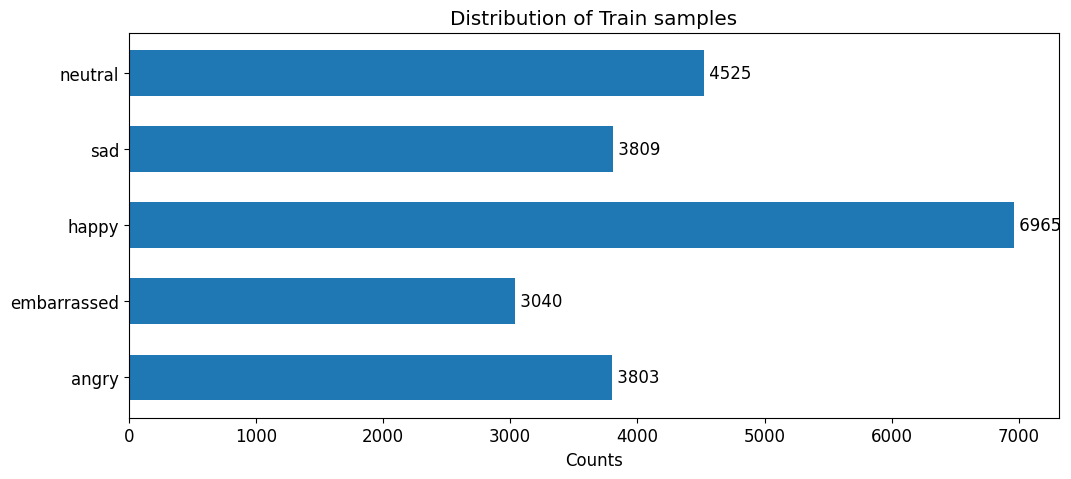

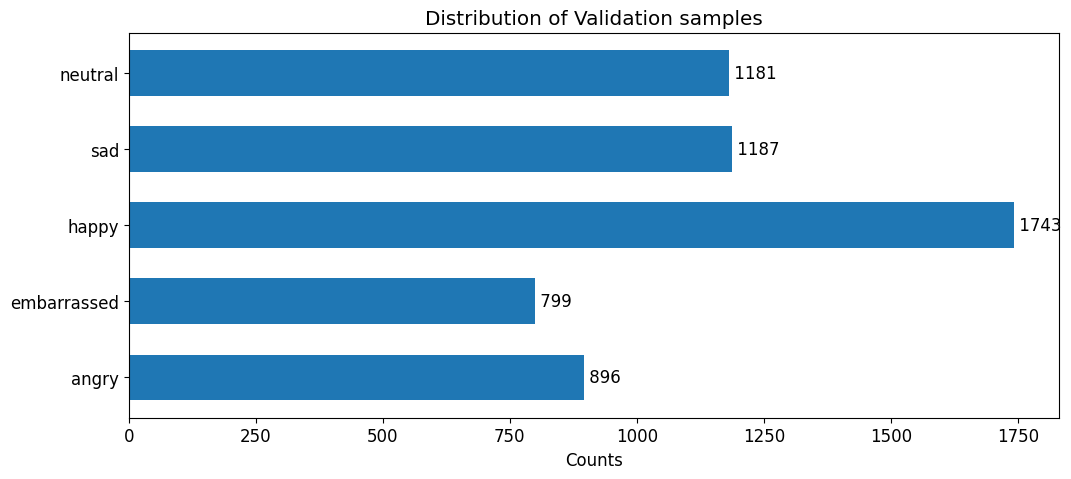

In [71]:
def plot_sample_distribution(labels, name=''):
    # 고유한 레이블과 그 개수를 계산합니다.
    classes, cnts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 5))  # 특정 크기의 새로운 그림을 생성합니다.
    plt.barh(list(emotions.values()), cnts, height=0.6)  # 수평 막대 그래프를 생성합니다.
    for i, v in enumerate(cnts):
        plt.text(v, i, ' ' + str(v), va='center')  # 각 막대에 개수 값을 표시합니다.
    plt.xlabel('Counts')  # x축의 레이블을 설정합니다.
    plt.title(f"Distribution of {name} samples")  # 플롯의 제목을 설정합니다.

# 함수를 호출하여 'labels' 배열을 기반으로 샘플 분포를 플롯합니다.
plot_sample_distribution(train_labels, 'Train')
plot_sample_distribution(validation_labels, 'Validation')


### **이미지 그리드 표시 (show_images)**

주어진 이미지 배열과 해당 레이블을 그리드 형태로 표시합니다.  
이미지 배열의 총 개수를 계산하고, 주어진 열 수에 따라 필요한 행 수를 결정합니다.  
각 이미지에 대해 plt.imshow를 사용하여 이미지를 그리드에 추가하고, 각 이미지 위에 해당하는 레이블을 제목으로 표시합니다.

In [72]:
def show_images(images, labels, col=5):
    n = images.shape[0]  # 이미지의 총 개수를 얻습니다.
    row = int(np.ceil(n / col))  # 주어진 열 수에 기반하여 행 수를 계산합니다.
    fig = plt.figure(figsize=(2 * col, 2 * row))  # 그리드를 표시하기 위한 그림을 생성합니다.

    for i in range(n):
        fig.add_subplot(row, col, i + 1)  # 각 이미지에 대해 하위 그림을 추가합니다.
        plt.imshow(images[i], cmap='gray')  # 회색조 색상맵을 사용하여 이미지를 표시합니다.
        plt.title(emotions[labels[i]])  # 해당 감정 레이블을 하위 그림의 제목으로 설정합니다.
        plt.xticks([]), plt.yticks([])  # x와 y축의 눈금을 제거합니다.

    plt.show()  # 이미지 그리드를 표시합니다.


### **특정 감정 이미지 표시 (show_one_emotion)**

특정 감정 레이블(id)에 해당하는 이미지만 필터링하여 그리드 형태로 보여줍니다.

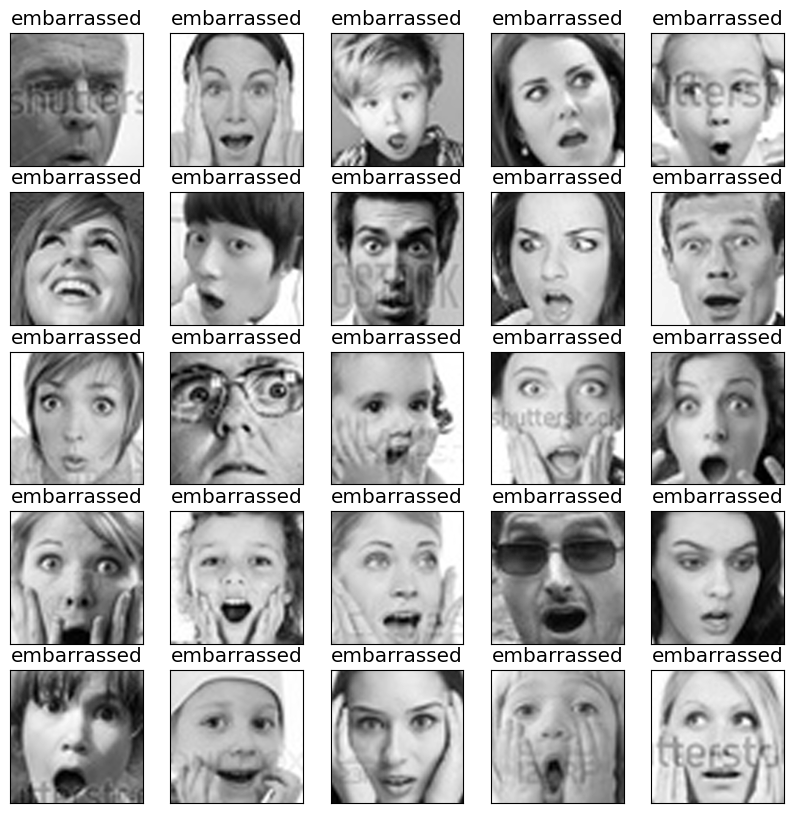

In [73]:
def show_one_emotion(images, labels, id, start=0, num=25):
    # 주어진 감정 레이블에 해당하는 이미지를 필터링합니다.
    image_x = images[labels == id]
    # 주어진 감정 레이블에 해당하는 레이블을 필터링합니다.
    label_x = labels[labels == id]    
    # show_images 함수를 호출하여 선택된 이미지와 필터링된 레이블을 함께 표시합니다.
    show_images(image_x[start:start + num], label_x[start:start + num])

# 함수를 호출하여 특정 감정 레이블에 해당하는 이미지를 표시합니다.
show_one_emotion(train_images, train_labels, id='1')


## **데이터셋 분포조정**
이미지 데이터셋의 데이터의 분포조정 과정을 다루며, 전처리 과정에서 쏠려있는 데이터 셋을 고르게 분포합니다.

___

### **셔플링 (shuffling)**

주어진 이미지와 레이블 배열을 무작위로 섞어 데이터의 순서를 임의로 변경합니다.  
난수 생성기의 시드를 설정하여 결과의 재현성을 보장합니다.

In [14]:
def shuffling(image, label,random_state = 42):
    # 난수 생성기의 시드 설정
    np.random.seed(random_state)
    indices = np.arange(len(image))
    # 인덱스에 따라 X와 y 데이터 섞기
    np.random.shuffle(indices)
    image_res = image[indices]
    label_res = label[indices]
    return image_res, label_res

In [15]:
# 훈련 데이터셋을 셔플링합니다.
image_train, label_train = shuffling(train_images, train_labels, random_state=42)
# 검증 데이터셋을 셔플링합니다.
image_validation, label_validation = shuffling(validation_images, validation_labels, random_state=42)

# 각 데이터셋 분할에 있는 샘플 수를 출력합니다.
print('Training samples:', label_train.shape[0])  # 훈련 세트의 샘플 수를 표시합니다.
print('Validation samples:', label_validation.shape[0])  # 검증 세트의 샘플 수를 표시합니다.

Training samples: 22142
Validation samples: 5806


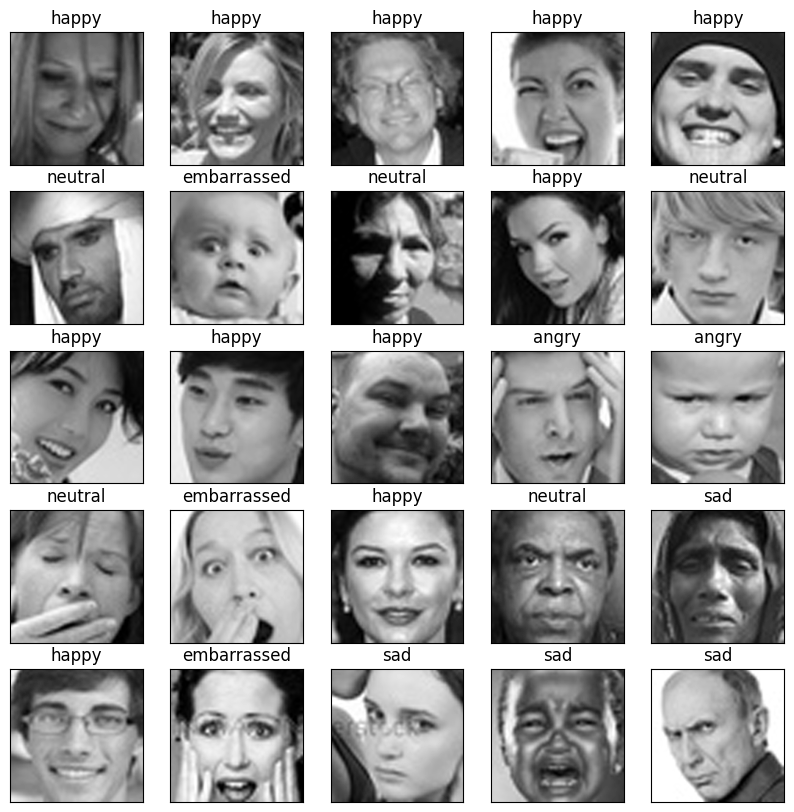

In [16]:
# 함수를 호출하여 첫 25개 이미지와 그 레이블을 표시합니다.
show_images(image_train[:25],  label_train[:25])

## **업샘플링 과정**
불균형한 데이터셋의 클래스 분포를 균형있게 만드는 데 초점을 맞춥니다.

___

In [17]:
def upsampling(x, y, strategy):
    """
    SMOTE 기법을 사용하여 클래스 분포를 균형있게 만들기 위한 업샘플링을 수행합니다.
    """
    (n, w, h) = x.shape  # 입력 이미지 데이터의 차원을 얻습니다.
    sm = SMOTE(sampling_strategy=strategy, random_state=42)  # 주어진 전략으로 SMOTE 객체를 생성합니다.
    x_flat = x.reshape((n, -1))  # 입력 이미지 데이터를 2D 배열로 변형합니다.
    x_up, y_up = sm.fit_resample(x_flat, y)  # SMOTE를 사용하여 리샘플링을 수행합니다.
    n_up = x_up.shape[0]  # 업샘플링된 데이터의 샘플 수를 얻습니다.
    x_up = x_up.reshape((n_up, w, h))  # 업샘플링된 데이터를 원래 형태로 변형합니다.

    return x_up, y_up  # 업샘플링된 이미지 데이터와 레이블을 반환합니다.

In [18]:
collections.Counter(label_train)

Counter({'2': 6965, '4': 4525, '3': 3809, '0': 3803, '1': 3040})

In [19]:
# 훈련 데이터에 대해 업샘플링을 수행합니다.
# 'auto' 전략을 사용하여 샘플링 비율을 자동으로 결정합니다.
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

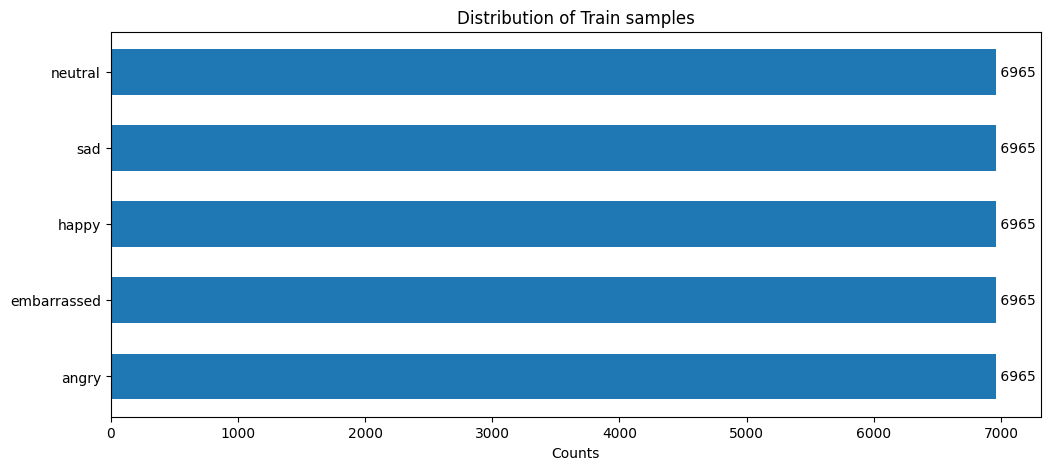

In [20]:
# 업샘플링 후 'label_train_up' 배열에서 각 레이블의 발생 횟수를 계산합니다.
plot_sample_distribution(label_train_up, 'Train')

## **이미지 데이터 전처리 및 모델 성능 평가 유틸리티**
이미지 데이터를 전처리하고, 학습 과정을 시각화하며, 모델의 성능을 평가하는 다양한 유틸리티 함수들을 정의합니다. 

___

### **원-핫 인코딩 함수 (one_hot_encoding)**

주어진 레이블 배열을 원-핫 인코딩 형식으로 변환합니다.  
Keras의 to_categorical 함수를 사용하여 각 레이블을 범주형 형식으로 변환합니다.  
이 함수는 모델 학습에 적합한 레이블 형식을 제공합니다.  

In [21]:
def one_hot_encoding(labels, num_classes):
    """
    주어진 레이블에 대해 원-핫 인코딩을 수행합니다.

    Args:
        labels (numpy.ndarray): 정수 레이블이 포함된 배열.
        num_classes (int): 전체 클래스의 수.

    Returns:
        numpy.ndarray: 원-핫 인코딩된 레이블이 포함된 배열.
    """
    # Keras 유틸리티를 사용하여 원-핫 인코딩을 수행합니다.
    return tf.keras.utils.to_categorical(labels, num_classes)


### **이미지 재형성 및 전처리 함수 (reshape_images)**

주어진 이미지 배열을 지정된 채널 수와 차원으로 재형성합니다.  
TensorFlow의 tf.convert_to_tensor 및 tf.image.resize 함수를 사용하여 이미지 데이터를 변환하고 필요에 따라 리사이징합니다.  
이 함수는 이미지 데이터를 모델에 입력하기 전에 적절한 형태로 조정합니다.  

In [22]:
def reshape_images(images, channel=1, resize=None):
    """
    일련의 이미지를 재형성하고 전처리합니다.

    Args:
        images (numpy.ndarray): 이미지 데이터가 포함된 배열.
        channel (int, optional): 이미지의 채널 수. 기본값은 1입니다.
        resize (tuple, optional): 리사이징 후 원하는 이미지 차원. 기본값은 None입니다.

    Returns:
        tensorflow.Tensor: 전처리된 이미지 텐서.
    """
    # 이미지 데이터를 텐서로 변환하고 추가 채널 차원을 추가합니다.
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        # 원하는 채널 수에 맞게 채널을 반복합니다.
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        # 이미지를 원하는 차원으로 리사이징합니다.
        x = tf.image.resize(x, resize)
    return x  # 전처리된 이미지 텐서를 반환합니다.

## **통합 전처리 함수 (pre_processing)**

이미지와 레이블 데이터를 전처리하고, 필요에 따라 원-핫 인코딩을 적용합니다.   
reshape_images 및 one_hot_encoding 함수를 내부적으로 호출하여 이미지와 레이블을 모델 학습에 적합한 형태로 변환합니다.

In [23]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    """
    전처리 함수: 이미지와 레이블을 처리합니다.

    Args:
        images (list or numpy.ndarray): 이미지 데이터의 리스트 또는 NumPy 배열.
        labels (list or numpy.ndarray): 레이블 데이터의 리스트 또는 NumPy 배열.
        num_classes (int): 전체 클래스의 수.
        channel (int, optional): 이미지의 채널 수. 기본값은 1입니다.
        resize (tuple, optional): 이미지 리사이징을 위한 타겟 크기 (높이, 너비). 기본값은 None입니다.
        one_hot (bool, optional): True이면 원-핫 인코딩을 적용합니다. 기본값은 True입니다.

    Returns:
        tuple: 전처리된 이미지 데이터와 레이블 데이터 (x, y)가 포함된 튜플.
    """
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes) if one_hot else labels
    return x, y

### **학습 메트릭 시각화 함수 (plot_metrics)**

모델의 학습 과정에서 기록된 메트릭(예: 손실 및 정확도)을 에포크별로 시각화합니다.  
학습 및 검증 단계에서의 메트릭 변화를 나란히 표시하여 모델의 성능을 평가하고 과적합 여부를 확인합니다.

In [24]:
def plot_metrics(history):
    """
    학습 메트릭을 에포크별로 플롯합니다.

    이 함수는 훈련 및 검증 메트릭(예: 손실 및 정확도)을 학습 에포크 동안 나란히 표시합니다.

    Args:
        history (keras.callbacks.History): Keras 모델의 `fit` 메소드에 의해 반환된 객체.

    Returns:
        None
    """
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1, 2, n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model ' + name)
        plt.legend()

    plt.show()


### ***클래스별 성능 평가 함수 (evaluate_class):**

모델이 테스트 데이터셋의 각 클래스에 대해 어떻게 수행하는지 평가합니다.   
각 클래스별 정확도를 출력하고 전체 테스트 데이터셋에 대한 모델의 성능을 평가합니다.    

In [25]:
def evaluate_class(model, x_test, y_test):
    """
    다양한 클래스에 대한 모델의 성능과 전체 정확도를 평가합니다.

    이 함수는 주어진 모델의 개별 클래스에 대한 성능과 제공된 테스트 데이터에 대한 전체 정확도를 평가합니다.

    Args:
        model (keras.models.Model): 훈련된 Keras 모델.
        x_test (numpy.ndarray): 테스트 입력 데이터.
        y_test (numpy.ndarray): 테스트 데이터에 대한 실제 레이블.

    Returns:
        None
    """
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    
    for i in range(num_classes):
        x = x_test[labels == i]
        y = y_test[labels == i]
        loss, acc = model.evaluate(x, y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[f'{i}'], acc))
    
    print('-'*23)
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))

## **Model**
모델을 구축하고 훈련하는 과정입니다.

___

### **모델 체크포인트 콜백 설정 (model_checkpoint_cb 함수)**

훈련 중 최고의 모델을 저장하기 위한 ModelCheckpoint 콜백을 생성합니다.  
검증 정확도가 개선될 때마다 모델의 가중치를 지정된 파일 경로에 저장합니다.

In [26]:
def model_checkpoint_cb(file_path):
    """
    훈련 중 최고의 모델을 저장하기 위한 ModelCheckpoint 콜백을 생성합니다.

    이 함수는 Keras ModelCheckpoint 콜백을 생성합니다. 이 콜백은 검증 정확도를 모니터링하고
    검증 정확도가 개선될 때 모델의 가중치를 저장합니다.

    Args:
        file_path (str): 모델 파일을 저장할 경로(파일명 포함).

    Returns:
        keras.callbacks.ModelCheckpoint: ModelCheckpoint 콜백 인스턴스.
    """
    return ModelCheckpoint(
        file_path, monitor='val_accuracy', mode='max',
        save_best_only=True, save_weights_only=True, verbose=1)

### **데이터 전처리 및 데이터 증강**

pre_processing 함수를 사용하여 훈련 및 검증 데이터셋을 전처리합니다.  
앞서 정의한 이미지 전처리 함수들을 사용합니다.

ImageDataGenerator를 사용하여 훈련 데이터에 대한 다양한 증강 기법(회전, 전단, 이동, 확대/축소, 수평 뒤집기)을 적용합니다.  
검증 데이터에 대해서는 증강을 적용하지 않습니다.

In [27]:
# 데이터 전처리
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_validation, label_validation, num_classes)

# 데이터 증강
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

# 배치 크기 설정
batch_size = 8

# 데이터 생성기 생성
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

# 훈련 파라미터 설정
steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

### **VGGNet 모델 정의**

VGG 스타일의 컨볼루션 신경망 모델을 정의하고, 모델 구조를 컴파일합니다.  
모델은 컨볼루션, 배치 정규화, 맥스풀링, 드롭아웃, 완전 연결층으로 구성됩니다.

In [29]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes, dropout_1=0, dropout_2=0, checkpoint_path=None, lr=1e-3):
        """
        VGG 스타일의 컨볼루션 신경망 모델.

        이 클래스는 Keras Sequential API를 사용하여 VGG 스타일의 컨볼루션 신경망 모델을 정의합니다.

        Args:
            input_shape (tuple): 입력 이미지의 형태 (높이, 너비, 채널).
            num_classes (int): 분류를 위한 클래스 수.
            checkpoint_path (str): 훈련 중 체크포인트를 저장할 경로.
            lr (float, optional): 옵티마이저의 학습률. 기본값은 1e-3입니다.

        Returns:
            None
        """
        super().__init__()

        # 입력 이미지의 크기를 정규화합니다.
        self.add(Rescaling(1./255, input_shape=input_shape))
        
        # 컨볼루션 블록
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_1))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_2))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_1))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_2))
        
        # 완전 연결층
        self.add(Flatten())
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(dropout_1))
        self.add(Dense(256, activation='relu'))

        # 출력층
        self.add(Dense(num_classes, activation='softmax'))

        # 모델 컴파일
        self.compile(optimizer=Adam(learning_rate=lr),
                     loss=categorical_crossentropy,
                     metrics=['accuracy'])

        # 체크포인트 경로 저장
        self.checkpoint_path = checkpoint_path

### **하이퍼파라미터 튜닝**
VGGNet 모델의 하이퍼파라미터를 조정하여 최적의 성능을 달성하기 위한 튜닝 과정을 다룹니다.  
그리드 서치를 통해 모든 가능한 하이퍼파라미터 조합을 시험하여 최적의 조합을 찾습니다.

In [30]:
# 모델 생성 함수를 정의합니다. 이 함수는 VGGNet 모델을 반환합니다.
def create_model(dropout_1=0.0, dropout_2=0.0, lr=1e-3):
    return VGGNet(input_shape=input_shape, num_classes=5, dropout_1=dropout_1, 
                  dropout_2=dropout_2, checkpoint_path=join_with_curr('models','vggnet_fer_trained.h5'), lr=lr)

# 드롭아웃 및 학습률에 대한 옵션을 설정합니다.
dropout_1_options = dropout_2_options = [0, 0.1, 0.2]
learning_rate_options = [1e-5, 1e-4, 1e-3, 1e-2]

# 가능한 모든 하이퍼파라미터 조합을 생성합니다.
hyperparam_combinations = []
for dropout_1 in dropout_1_options:
    for dropout_2 in dropout_2_options:
        for lr in learning_rate_options:
            hyperparam_combinations.append((dropout_1, dropout_2, lr))

In [31]:
results = []
for dropout_1, dropout_2, lr in hyperparam_combinations:
    clear_session()
    model = create_model(dropout_1=dropout_1, dropout_2=dropout_2, lr=lr)
    model.fit(train_generator, epochs=10, batch_size=batch_size)
    
    # 모델의 성능을 평가합니다.
    performance = model.evaluate(val_generator)
    
    results.append((dropout_1, dropout_2, lr, performance))
    del model
    gc.collect()
    
best_performance = None
best_hyperparams = None

for dropout_1, dropout_2, lr, performance in results:
    if best_performance is None or performance > best_performance:
        best_performance = performance
        best_hyperparams = (dropout_1, dropout_2, lr)

In [32]:
print("최적의 하이퍼파라미터:", best_hyperparams)

최적의 하이퍼파라미터: (0.1, 0.1, 0.0001)


### **모델 훈련 설정**

배치 크기, 스텝 수, 콜백(모델 체크포인트, 학습률 감소, 조기 종료)을 설정합니다.  
fit 메소드를 사용하여 모델을 훈련 데이터셋으로 훈련하고, 검증 데이터셋으로 성능을 평가합니다.

In [33]:
# VGGNet 모델 인스턴스를 생성합니다.
dropout_1 = 0.1  # 첫 번째 드롭아웃 비율
dropout_2 = 0.1  # 두 번째 드롭아웃 비율
model_path = join_with_curr('models', 'vggnet_fer_trained.h5')  # 모델 저장 경로
model = VGGNet(input_shape, num_classes, dropout_1, dropout_2, model_path, lr=1e-4)  # 모델 생성

# 모델의 구조를 요약하여 출력합니다.
model.summary()

Model: "vgg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0   

In [34]:
# 훈련할 에포크 수를 설정합니다.
epochs = 500
# 콜백을 정의합니다.
cp = model_checkpoint_cb(model.checkpoint_path)  # 모델 체크포인트 저장
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-10)  # 학습률 조정
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)  # 조기 종료

# 모델 훈련을 시작합니다.
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[lr, es, cp])  # 정의된 콜백을 훈련에 적용


Epoch 1/500
4353/4353 [==============================] - ETA: 0s - loss: 1.8516 - accuracy: 0.2620
Epoch 1: val_accuracy improved from -inf to 0.33810, saving model to C:\Users\royal\Desktop\ML\project\models\vggnet_fer_trained.h5
4353/4353 [==============================] - 130s 30ms/step - loss: 1.8516 - accuracy: 0.2620 - val_loss: 1.5191 - val_accuracy: 0.3381 - lr: 1.0000e-04
Epoch 2/500
4352/4353 [============================>.] - ETA: 0s - loss: 1.4970 - accuracy: 0.3331
Epoch 2: val_accuracy improved from 0.33810 to 0.39804, saving model to C:\Users\royal\Desktop\ML\project\models\vggnet_fer_trained.h5
4353/4353 [==============================] - 128s 29ms/step - loss: 1.4969 - accuracy: 0.3332 - val_loss: 1.4609 - val_accuracy: 0.3980 - lr: 1.0000e-04
Epoch 3/500
4352/4353 [============================>.] - ETA: 0s - loss: 1.3308 - accuracy: 0.4204
Epoch 3: val_accuracy improved from 0.39804 to 0.53462, saving model to C:\Users\royal\Desktop\ML\project\models\vggnet_fer_traine

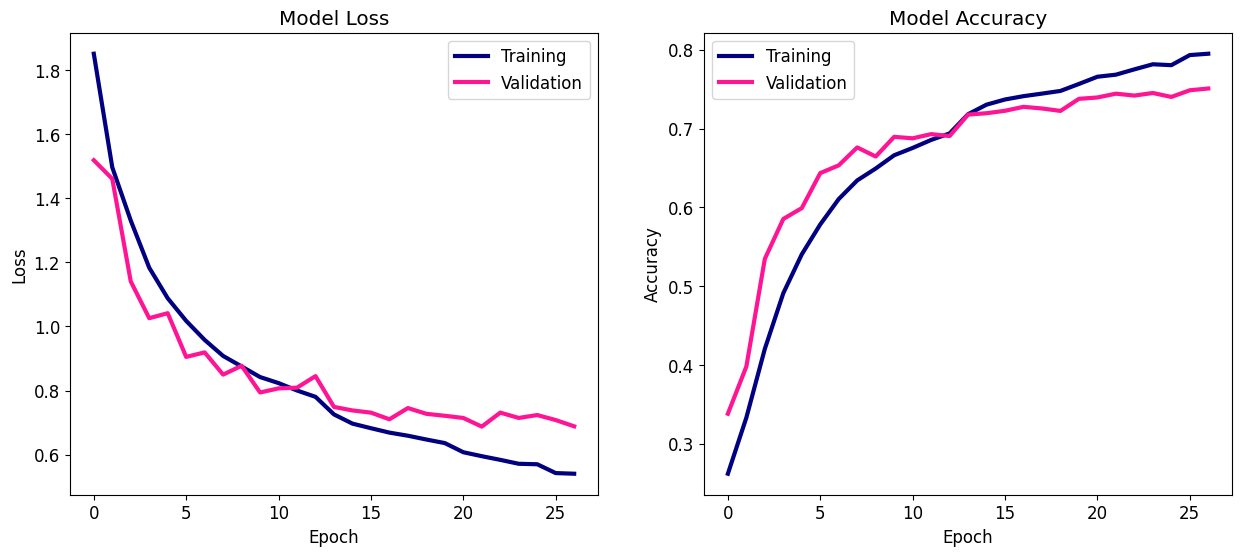

In [83]:
# 훈련 과정에서의 성능 메트릭을 시각화합니다.
plot_metrics(history)

In [84]:
# emo 사전에 있는 각 감정 레이블에 대해 반복합니다.
for e in emo:
    print(e)
    korean_test_csv = join_with_curr('dataset', 'test', 'csvs', e + '.csv')
    data_file = pd.read_csv(korean_test_csv)  # CSV 파일을 pandas DataFrame으로 로드합니다.
    print(data_file[:5])
    exist_check(data_file, korean_test_csv)  # 이미지 존재 여부를 확인하고 새로운 데이터셋 CSV 파일을 생성합니다.
# 모든 감정 레이블에 대한 CSV 파일을 병합합니다.
korean_test_csv = join_with_curr('dataset', 'test', 'csvs')
merge_csv_vertical(korean_test_csv)

angry
                                                path  label
0  ./dataset/test/angry/00varoy0jfvqrn2hrxxqtikwv...  angry
1  ./dataset/test/angry/01dbm4duono2tgvo3cbnjetcs...  angry
2  ./dataset/test/angry/02ep7tbnfrstjwulsntntdeys...  angry
3  ./dataset/test/angry/02teqi8isrnvly0bhym2qrcym...  angry
4  ./dataset/test/angry/03obmmx0cghukadf36wtddmtd...  angry
Loading data ...
exist check finished.
embarrassed
                                                path        label
0  ./dataset/test/embarrassed/00v7jnyq4rxsyleebxt...  embarrassed
1  ./dataset/test/embarrassed/01dlhtabbbgkntvget0...  embarrassed
2  ./dataset/test/embarrassed/01lgflaxqlnuttmlg4v...  embarrassed
3  ./dataset/test/embarrassed/02jlpjd2ngs2yar0gra...  embarrassed
4  ./dataset/test/embarrassed/04kiitapjpb7qkgf7ly...  embarrassed
Loading data ...
exist check finished.
happy
                                                path  label
0  ./dataset/test/happy/00gdhjcvi8lb0ifnwubnvohre...  happy
1  ./dataset/test/happ

Data loaded.
Korean test samples: 36597
Korean test images shape: (36597, 224, 224)
Korean test labels shape: (36597,)


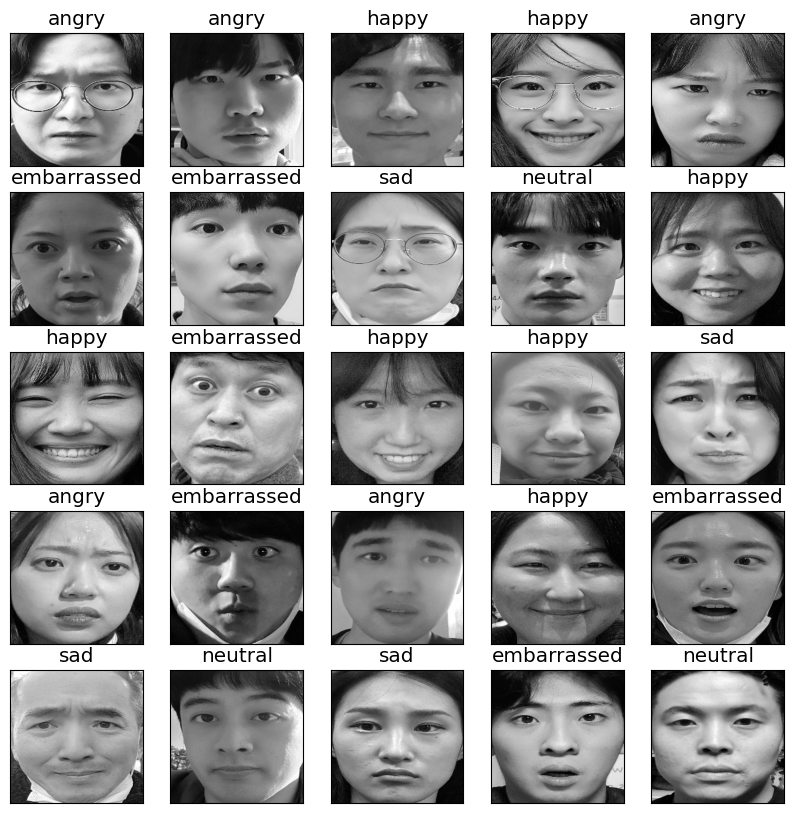

In [85]:
# 병합된 CSV 파일의 경로를 설정합니다.
korean_test_csv_merged = os.path.join(korean_test_csv, 'merged.csv')
# 데이터를 로드합니다.
korean_test_images, korean_test_labels = load_data(korean_test_csv_merged)
# 데이터셋의 샘플 수를 계산합니다.
korean_test_n_samples = korean_test_labels.shape[0]

# 데이터셋 정보를 출력합니다.
print('Korean test samples:', korean_test_n_samples)
print('Korean test images shape:', korean_test_images.shape)
print('Korean test labels shape:', korean_test_labels.shape)



# 데이터셋을 셔플링합니다.
korean_image_test, korean_label_test = shuffling(korean_test_images, korean_test_labels, random_state=42)
# 처음 25개의 이미지를 표시합니다.
show_images(korean_image_test[:25], korean_label_test[:25])

In [86]:
print(np.unique(korean_test_labels, return_counts=True))

(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([7420, 7012, 7492, 7462, 7211], dtype=int64))


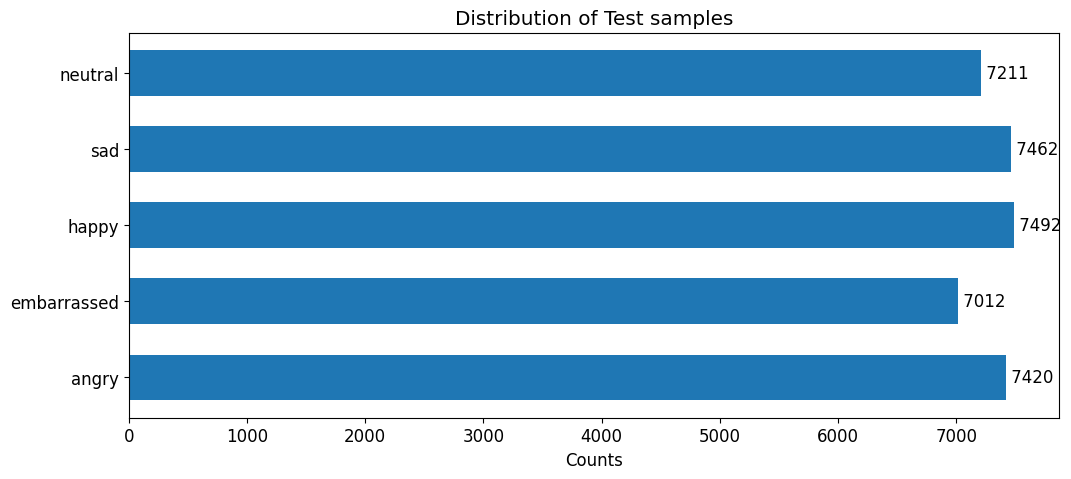

In [87]:
# 샘플 분포를 시각화합니다.
plot_sample_distribution(korean_test_labels,'Test')

In [95]:
# 최적의 모델 가중치를 체크포인트에서 로드합니다.
model.load_weights(model.checkpoint_path)
model.eval()
# 테스트 데이터에 대해 모델을 평가합니다.
evaluate_class(model, korean_test_images, korean_test_labels)

Emotion        Accuracy
-----------------------
angry          64.3%
embarrassed    50.7%
happy          2.3%
sad            19.9%
neutral        44.6%
-----------------------
Overall        36.1%


In [96]:
# 훈련된 모델을 저장합니다.
model.save(model.checkpoint_path)